### Chain and multioutput regression models for predicting V, A and D consecutively

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

data_01=pd.read_csv('Emo_Bank_VAD.csv')

print(data_01.columns)
print('')
print(data_01.shape)
print(data_01.head())
print('')
print(data_01.dtypes)

Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


### Chain regression

In [3]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Define the RegressorChain with Ridge as the base estimator
base_estimator = Ridge()
regressor_chain = RegressorChain(base_estimator=base_estimator, order=[0,1,2])

#Vectorize "text" data
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'base_estimator__alpha': [0.1, 1.0, 10.0],
    'order': [[0, 1, 2]]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor_chain, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(x_train_tfidf, y_train)

# Get the best model from GridSearchCV
best_regressor_chain = grid_search.best_estimator_

# Predict on training, validation, and test datasets
y_train_pred = best_regressor_chain.predict(x_train_tfidf)
y_val_pred = best_regressor_chain.predict(x_val_tfidf)
y_test_pred = best_regressor_chain.predict(x_test_tfidf)

# Convert targets and predictions to numpy arrays 
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()

y_train_pred_np = np.array(y_train_pred)
y_val_pred_np = np.array(y_val_pred)
y_test_pred_np = np.array(y_test_pred)

# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model performance using RMSE, MSE, and MAE
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for train, validation, and test datasets
train_metrics = evaluate_performance(y_train_np, y_train_pred_np)
val_metrics = evaluate_performance(y_val_np, y_val_pred_np)
test_metrics = evaluate_performance(y_test_np, y_test_pred_np)


print(f'Best parameters: {grid_search.best_params_}\n')

print("Train Dataset:")
print(f'RMSE for V: {round(train_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(train_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(train_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(train_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(train_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(train_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(train_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(train_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(train_metrics["MSE_D"], 2)}\n')

print("Validation Dataset:")
print(f'RMSE for V: {round(val_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(val_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(val_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(val_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(val_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(val_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(val_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(val_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(val_metrics["MSE_D"], 2)}\n')

print("Test Dataset:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')



Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)
Best parameters: {'base_estimator__alpha': 1.0, 'order': [0, 1, 2]}

Train Dataset:
RMSE for V: 0.19
RMSE for A: 0.16
RMSE for D: 0.14

MAE for V: 0.14
MAE for A: 0.12
MAE for D: 0.1

MSE for V: 0.04
MSE for A: 0.03
MSE for D: 0.02

Validation Dataset:
RMSE for V: 0.3
RMSE for A: 0.25
RMSE for D: 0.22

MAE for V: 0.22
MAE for A: 0.19
MAE for D: 0.17

MSE for V: 0.09
MSE for A: 0.06
MSE for D: 0.05

Test Dataset:
RMSE for V: 0.3
RMSE for A: 0.26
RMSE for D: 0.22

MAE for V: 0.22
MAE for A: 0.19
MAE for D: 0.16

MSE for V: 0.09
MSE for A: 0.07
MSE for D: 0.05



In [4]:
# Create tables to compare predicted and real values

# Convert predictions to DataFrames and round to two decimals
y_train_pred_df = pd.DataFrame(y_train_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)
y_val_pred_df = pd.DataFrame(y_val_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)

# Concatenate real and predicted values
train_comparison = pd.concat([y_train.reset_index(drop=True), y_train_pred_df], axis=1)
val_comparison = pd.concat([y_val.reset_index(drop=True), y_val_pred_df], axis=1)
test_comparison = pd.concat([y_test.reset_index(drop=True), y_test_pred_df], axis=1)

# Print comparison tables
print("Training Data Comparison:\n", train_comparison.head())
print("\nValidation Data Comparison:\n", val_comparison.head())
print("\nTest Data Comparison:\n", test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_chain.csv", index=False)
val_comparison.to_csv("val_comparison_chain.csv", index=False)
test_comparison.to_csv("test_comparison_chain.csv", index=False)

Training Data Comparison:
       V     A     D  V_pred  A_pred  D_pred
0  3.00  2.70  3.10    3.02    2.91    3.11
1  2.50  3.10  2.80    2.70    3.05    2.95
2  2.30  3.10  2.80    2.63    3.18    2.88
3  3.56  3.33  3.11    3.43    3.21    3.09
4  3.00  3.00  3.00    2.99    3.01    3.03

Validation Data Comparison:
       V     A     D  V_pred  A_pred  D_pred
0  3.10  3.10  3.80    3.19    3.23    3.01
1  2.90  2.90  2.90    3.05    3.03    3.05
2  3.00  3.43  3.43    2.47    3.03    2.98
3  3.11  3.00  3.22    2.89    2.95    2.93
4  3.00  3.20  3.10    2.95    3.01    3.02

Test Data Comparison:
      V     A    D  V_pred  A_pred  D_pred
0  2.9  2.20  2.9    3.04    3.09    2.99
1  2.6  3.20  2.9    2.86    3.03    3.07
2  3.0  2.86  3.0    2.99    2.93    3.08
3  2.9  2.70  3.1    2.82    2.93    2.92
4  3.0  2.78  3.0    3.02    2.95    3.10


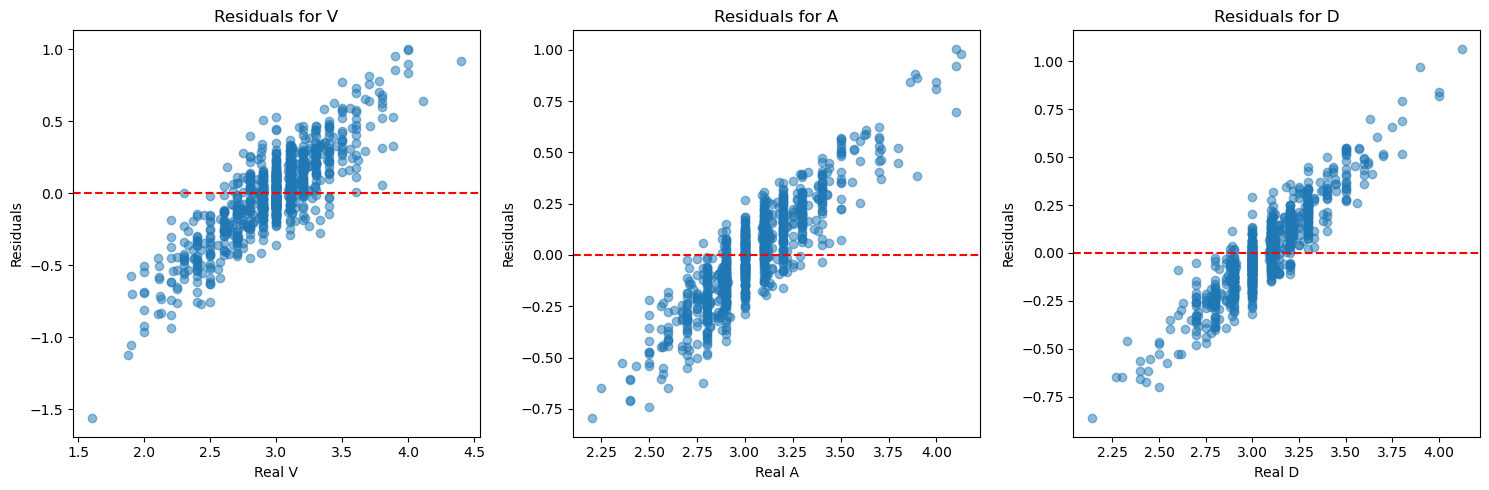

In [5]:
# Calculate residuals
residuals_v = y_val_np[:, 0] - y_val_pred_np[:, 0]
residuals_a = y_val_np[:, 1] - y_val_pred_np[:, 1]
residuals_d = y_val_np[:, 2] - y_val_pred_np[:, 2]

# Visualize the residuals
plt.figure(figsize=(15, 5))

# Residuals for V
plt.subplot(1, 3, 1)
plt.scatter(y_val_np[:, 0], residuals_v, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real V')
plt.ylabel('Residuals')
plt.title('Residuals for V')

# Residuals for A
plt.subplot(1, 3, 2)
plt.scatter(y_val_np[:, 1], residuals_a, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real A')
plt.ylabel('Residuals')
plt.title('Residuals for A')

# Residuals for D
plt.subplot(1, 3, 3)
plt.scatter(y_val_np[:, 2], residuals_d, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real D')
plt.ylabel('Residuals')
plt.title('Residuals for D')

plt.tight_layout()
plt.show()



### Multioutput regression

In [6]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

#Vectorize "text" data
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

# Initialize the Ridge regressor
ridge = Ridge()

# Define a parameter grid for Ridge regression
param_grid = {
    'estimator__alpha': [0.1, 1, 10, 100] 
}

# Set up the MultiOutputRegressor with GridSearchCV
multi_output_ridge = MultiOutputRegressor(ridge)
grid_search = GridSearchCV(multi_output_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with hyperparameter tuning
grid_search.fit(x_train_tfidf, y_train)

# Best parameters from GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Predict on train, validation, and test datasets
y_train_pred = grid_search.predict(x_train_tfidf)
y_val_pred = grid_search.predict(x_val_tfidf)
y_test_pred = grid_search.predict(x_test_tfidf)

# Convert targets and predictions to numpy arrays for consistency
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()
y_train_pred_np = np.array(y_train_pred)
y_val_pred_np = np.array(y_val_pred)
y_test_pred_np = np.array(y_test_pred)
# Evaluate the model performance using RMSE, MSE, and MAE
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for train, validation, and test datasets
train_metrics = evaluate_performance(y_train_np, y_train_pred_np)
val_metrics = evaluate_performance(y_val_np, y_val_pred_np)
test_metrics = evaluate_performance(y_test_np, y_test_pred_np)


print(f'Best parameters: {grid_search.best_params_}\n')

print("Train Dataset:")
print(f'RMSE for V: {round(train_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(train_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(train_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(train_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(train_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(train_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(train_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(train_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(train_metrics["MSE_D"], 2)}\n')

print("Validation Dataset:")
print(f'RMSE for V: {round(val_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(val_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(val_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(val_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(val_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(val_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(val_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(val_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(val_metrics["MSE_D"], 2)}\n')

print("Test Dataset:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')



Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)
Best parameters found:  {'estimator__alpha': 1}
Best parameters: {'estimator__alpha': 1}

Train Dataset:
RMSE for V: 0.19
RMSE for A: 0.16
RMSE for D: 0.14

MAE for V: 0.14
MAE for A: 0.12
MAE for D: 0.1

MSE for V: 0.04
MSE for A: 0.03
MSE for D: 0.02

Validation Dataset:
RMSE for V: 0.3
RMSE for A: 0.25
RMSE for D: 0.22

MAE for V: 0.22
MAE for A: 0.19
MAE for D: 0.17

MSE for V: 0.09
MSE for A: 0.06
MSE for D: 0.05

Test Dataset:
RMSE for V: 0.3
RMSE for A: 0.26
RMSE for D: 0.22

MAE for V: 0.22
MAE for A: 0.19
MAE for D: 0.16

MSE for V: 0.09
MSE for A: 0.07
MSE for D: 0.05



In [7]:
# Create tables to compare predicted and real values

# Convert predictions to DataFrames and round to two decimals
y_train_pred_df = pd.DataFrame(y_train_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)
y_val_pred_df = pd.DataFrame(y_val_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["V_pred", "A_pred", "D_pred"]).round(2)

# Concatenate real and predicted values
train_comparison = pd.concat([y_train.reset_index(drop=True), y_train_pred_df], axis=1)
val_comparison = pd.concat([y_val.reset_index(drop=True), y_val_pred_df], axis=1)
test_comparison = pd.concat([y_test.reset_index(drop=True), y_test_pred_df], axis=1)

# Print comparison tables
print("Training Data Comparison:\n", train_comparison.head())
print("\nValidation Data Comparison:\n", val_comparison.head())
print("\nTest Data Comparison:\n", test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_mo.csv", index=False)
val_comparison.to_csv("val_comparison_mo.csv", index=False)
test_comparison.to_csv("test_comparison_mo.csv", index=False) 



Training Data Comparison:
       V     A     D  V_pred  A_pred  D_pred
0  3.00  2.70  3.10    3.02    2.91    3.11
1  2.50  3.10  2.80    2.70    3.05    2.95
2  2.30  3.10  2.80    2.63    3.18    2.88
3  3.56  3.33  3.11    3.43    3.21    3.09
4  3.00  3.00  3.00    2.99    3.01    3.03

Validation Data Comparison:
       V     A     D  V_pred  A_pred  D_pred
0  3.10  3.10  3.80    3.19    3.23    3.01
1  2.90  2.90  2.90    3.05    3.03    3.05
2  3.00  3.43  3.43    2.47    3.03    2.98
3  3.11  3.00  3.22    2.89    2.95    2.93
4  3.00  3.20  3.10    2.95    3.01    3.02

Test Data Comparison:
      V     A    D  V_pred  A_pred  D_pred
0  2.9  2.20  2.9    3.04    3.09    2.99
1  2.6  3.20  2.9    2.86    3.03    3.07
2  3.0  2.86  3.0    2.99    2.93    3.08
3  2.9  2.70  3.1    2.82    2.93    2.92
4  3.0  2.78  3.0    3.02    2.95    3.10


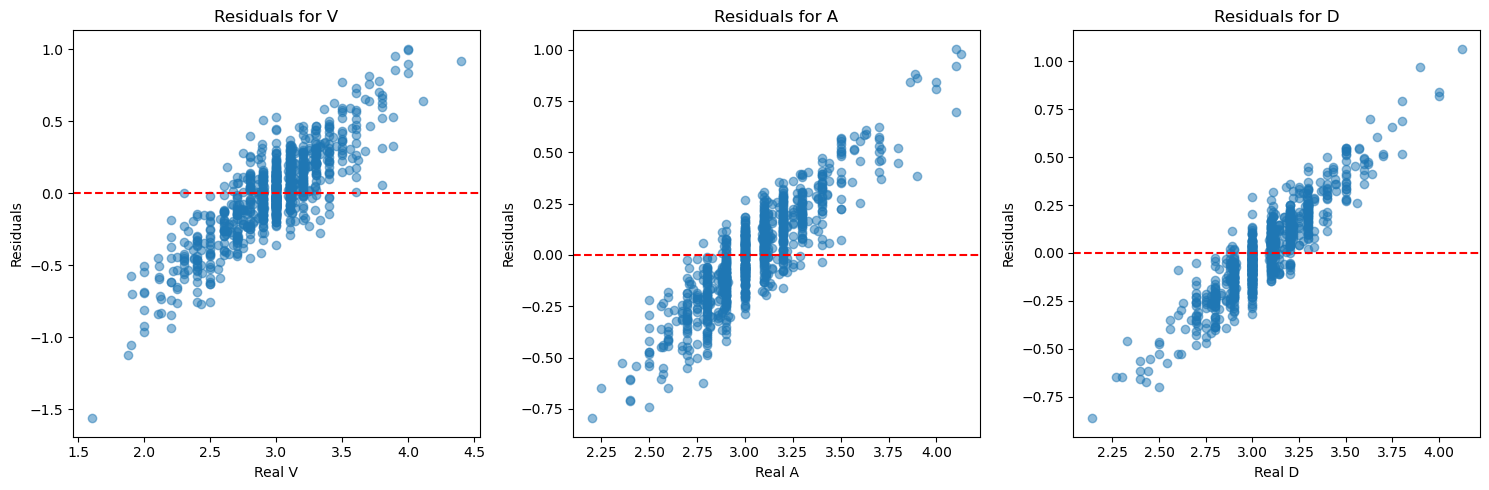

In [8]:
# Calculate residuals
residuals_v = y_val_np[:, 0] - y_val_pred_np[:, 0]
residuals_a = y_val_np[:, 1] - y_val_pred_np[:, 1]
residuals_d = y_val_np[:, 2] - y_val_pred_np[:, 2]

# Visualize the residuals
plt.figure(figsize=(15, 5))

# Residuals for V
plt.subplot(1, 3, 1)
plt.scatter(y_val_np[:, 0], residuals_v, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real V')
plt.ylabel('Residuals')
plt.title('Residuals for V')

# Residuals for A
plt.subplot(1, 3, 2)
plt.scatter(y_val_np[:, 1], residuals_a, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real A')
plt.ylabel('Residuals')
plt.title('Residuals for A')

# Residuals for D
plt.subplot(1, 3, 3)
plt.scatter(y_val_np[:, 2], residuals_d, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real D')
plt.ylabel('Residuals')
plt.title('Residuals for D')

plt.tight_layout()
plt.show()

